In [1]:
# Standard library imports
from argparse import ArgumentParser
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

# local application imports
from lag_caVAE.lag import Lag_Net
from lag_caVAE.nn_models import MLP_Encoder, MLP, MLP_Decoder, PSD
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform
from utils import arrange_data, from_pickle, my_collate, ImageDataset
from examples.cart_lag_cavae_trainer import Model

seed_everything(0)
%matplotlib inline
DPI = 600

## Load Model

In [2]:
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'cart-lag-cavae-T_p=4-epoch=206.ckpt')
model = Model.load_from_checkpoint(checkpoint_path)

## Prepare Data

In [3]:
data_path=os.path.join(PARENT_DIR, 'datasets', 'cartpole-gym-image-dataset-rgb-u9-test.pkl')
test_dataset = ImageDataset(data_path, 19, ctrl=False)

test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=my_collate)

In [4]:
test_batch = next(iter(test_dataloader))
X, u = test_batch

In [5]:
model.t_eval = torch.from_numpy(test_dataset.t_eval)
model.hparams.solver = 'rk4'
model(X, u)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


### check learned cart image (single channel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


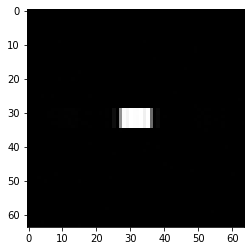

In [6]:
# cart
fig = plt.figure()
grid = utils.make_grid(model.cart[0].view(-1, 1, 64, 64), nrow = 5)
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

### check learned pole image (single channel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


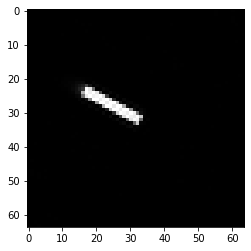

In [7]:
# pole
fig = plt.figure()
grid = utils.make_grid(model.pole[0].view(-1, 1, 64, 64), nrow = 5)
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

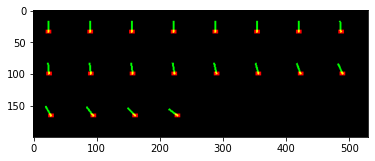

In [8]:
# data trajectory
b_ind = 0
grid = utils.make_grid(X[:, b_ind])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


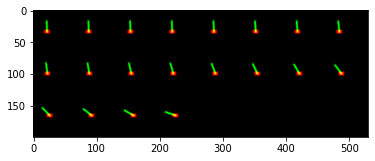

In [9]:
# prediction trajectory
grid = utils.make_grid(model.Xrec[:, b_ind])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

## check how learned potential energy varies with $\phi$
### Plot learned potential energy

In [10]:
phi = np.linspace(0, 2*np.pi, 41)
r = np.linspace(0, 0, 40)
cos_phi = np.cos(phi[:-1]) ; sin_phi = np.sin(phi[:-1])
r_cos_phi_sin_phi = np.stack([r, cos_phi, sin_phi], axis=1)
r_cos_phi_sin_phi = torch.tensor(r_cos_phi_sin_phi, dtype=torch.float32)

(-50.0, 50.0)

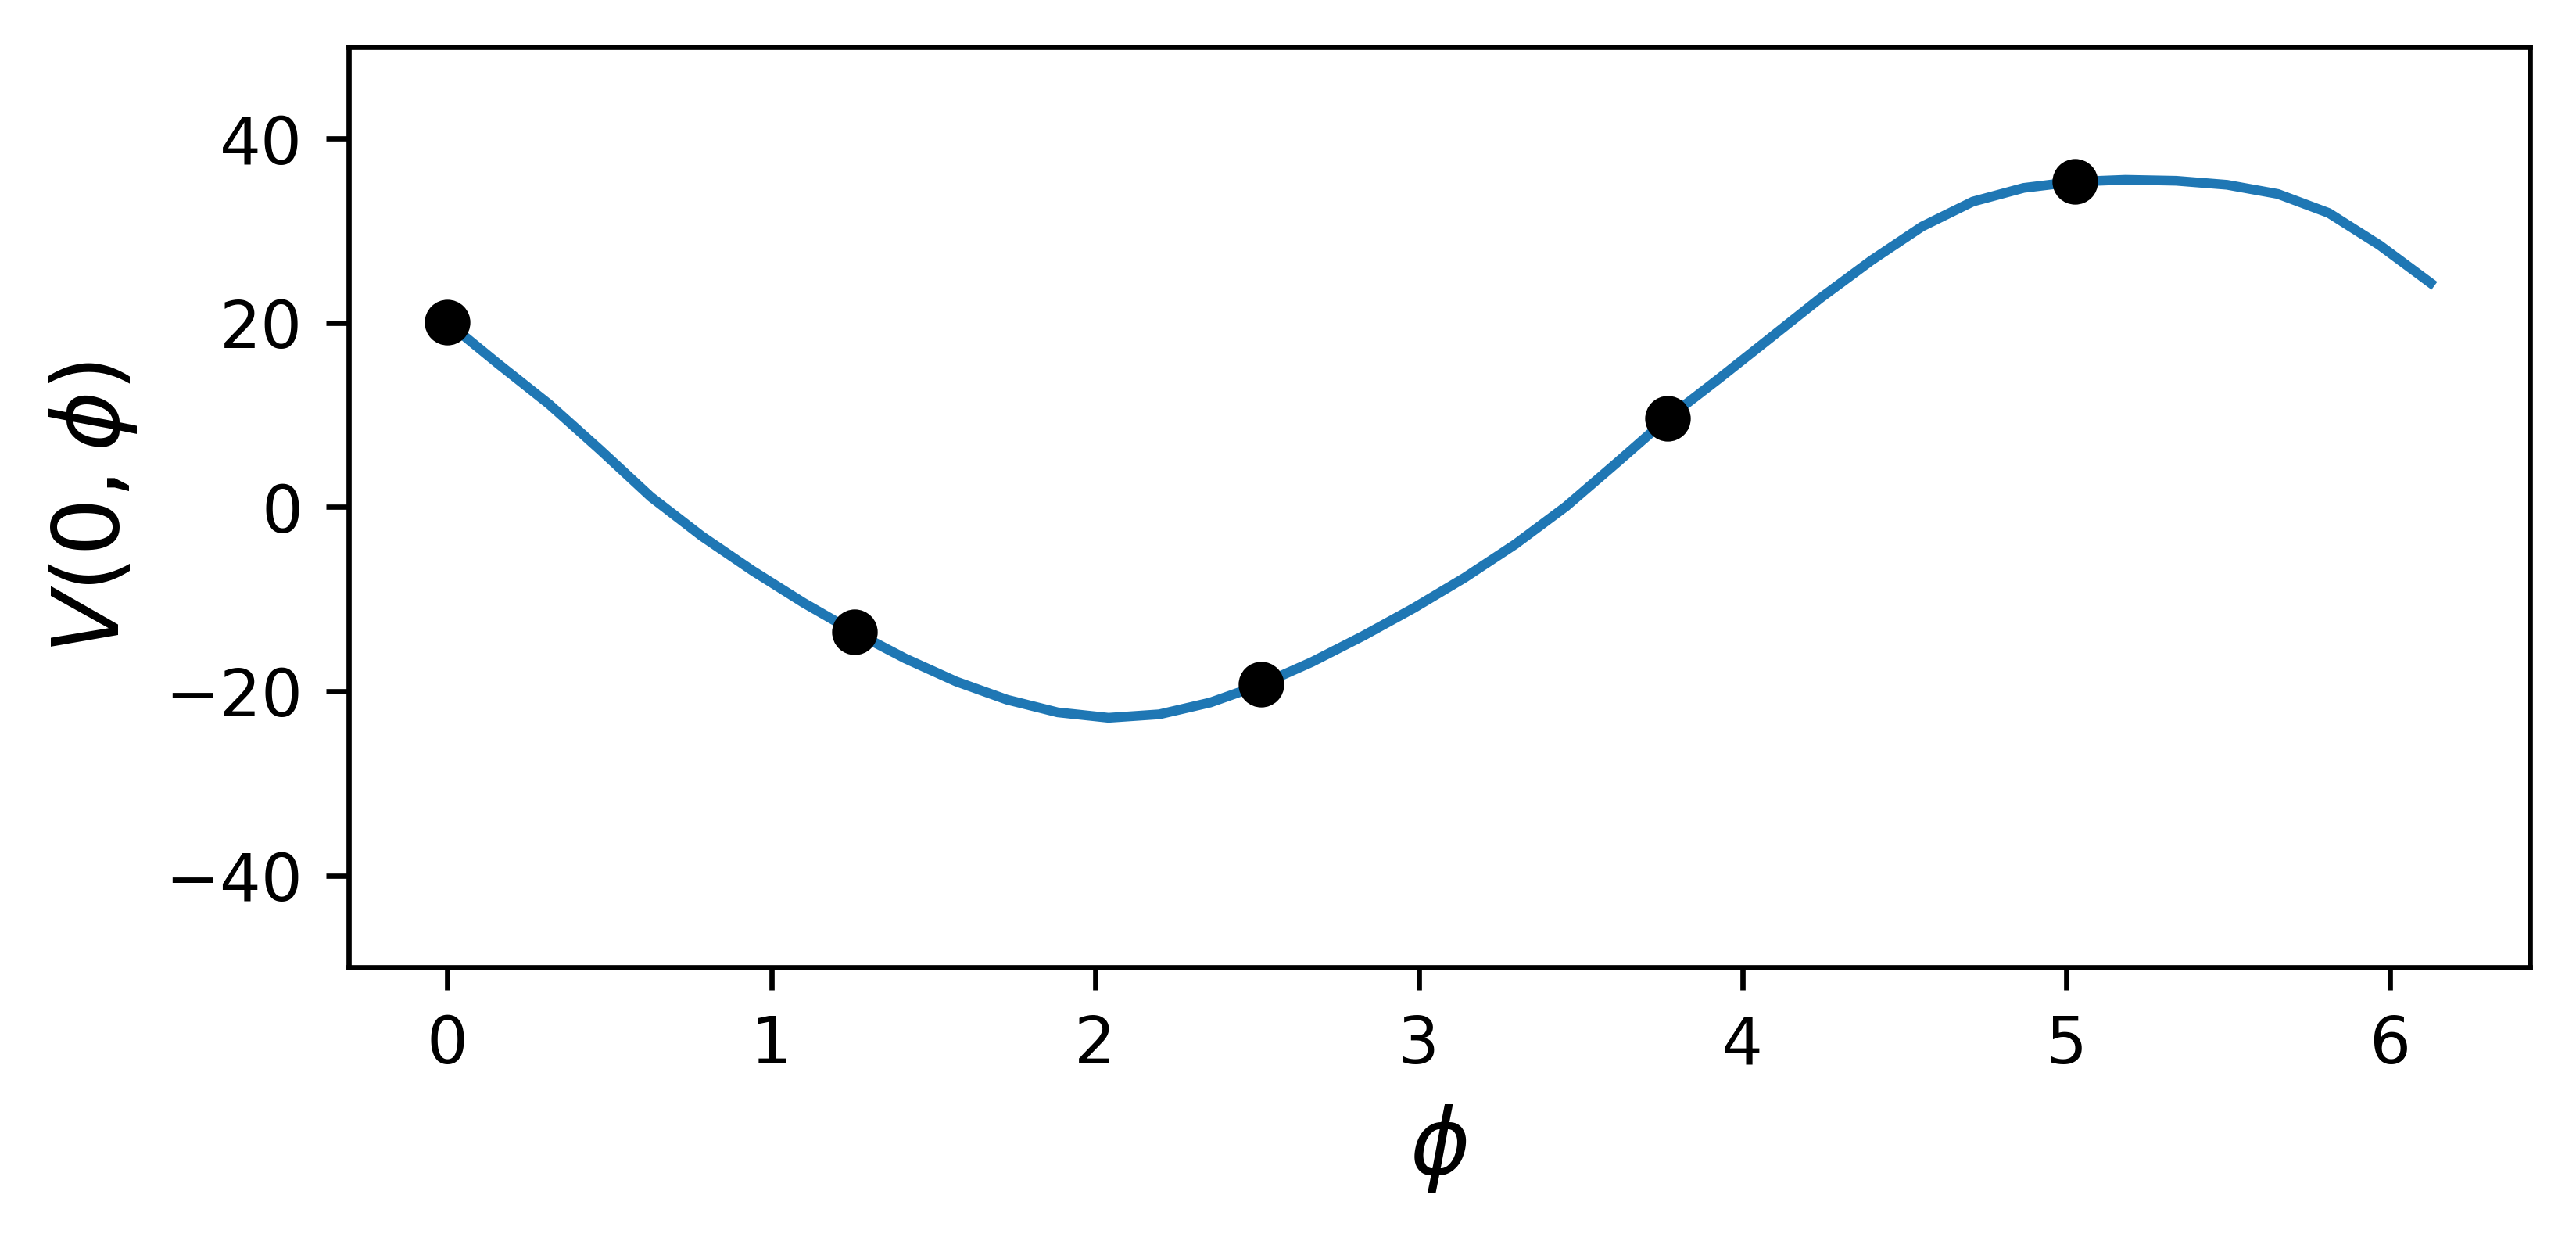

In [11]:
V_q = model.ode.V_net(r_cos_phi_sin_phi).detach().cpu().numpy()
markers_on = [0, 8, 16, 24, 32]
fig = plt.figure(figsize=[6, 2.6], dpi=DPI)
plt.plot(phi[:-1], V_q, marker = 'o', markevery=markers_on, markerfacecolor=(0,0,0,1), markeredgecolor=(0,0,0,1))
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel(r"$V(0, \phi)$", fontsize=14)
plt.ylim([-50, 50])

### plot 5 reconstruction images corresponding to the 5 black dots

In [12]:
ones = torch.ones_like(r_cos_phi_sin_phi[:, 0:1])
cart = model.obs_net_1(ones)
pole = model.obs_net_2(ones)

theta1 = model.get_theta_inv(1, 0, r_cos_phi_sin_phi[:, 0], 0, bs=40)
theta2 = model.get_theta_inv(r_cos_phi_sin_phi[:, 1], r_cos_phi_sin_phi[:, 2], r_cos_phi_sin_phi[:, 0], 0, bs=40)

grid1 = F.affine_grid(theta1, torch.Size((40, 1, 64, 64)))
grid2 = F.affine_grid(theta2, torch.Size((40, 1, 64, 64)))

transf_cart = F.grid_sample(cart.view(40, 1, 64, 64), grid1)
transf_pole = F.grid_sample(pole.view(40, 1, 64, 64), grid2)
Xrec = torch.cat([transf_cart, transf_pole, torch.zeros_like(transf_cart)], dim=1)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


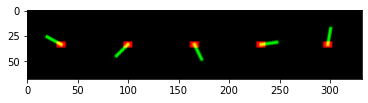

In [13]:
# for i in [0, 8, 16, 24, 32]:
#     fig = plt.figure()
#     plt.imshow(Xrec[i].permute(1,2,0).detach().cpu().numpy())
#     plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'cart_recon_phi_{i}.png'), bbox_inches='tight')
grid = utils.make_grid(Xrec[0:40:8])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

## check how leanrned potential energy varies with $r$

In [14]:
phi = np.linspace(0, 0, 40)
r = np.linspace(-1.0, 1.0, 40)

cos_phi = np.cos(phi) ; sin_phi = np.sin(phi)
r_cos_phi_sin_phi = np.stack([r, cos_phi, sin_phi], axis=1)
r_cos_phi_sin_phi = torch.tensor(r_cos_phi_sin_phi, dtype=torch.float32)

(-50.0, 50.0)

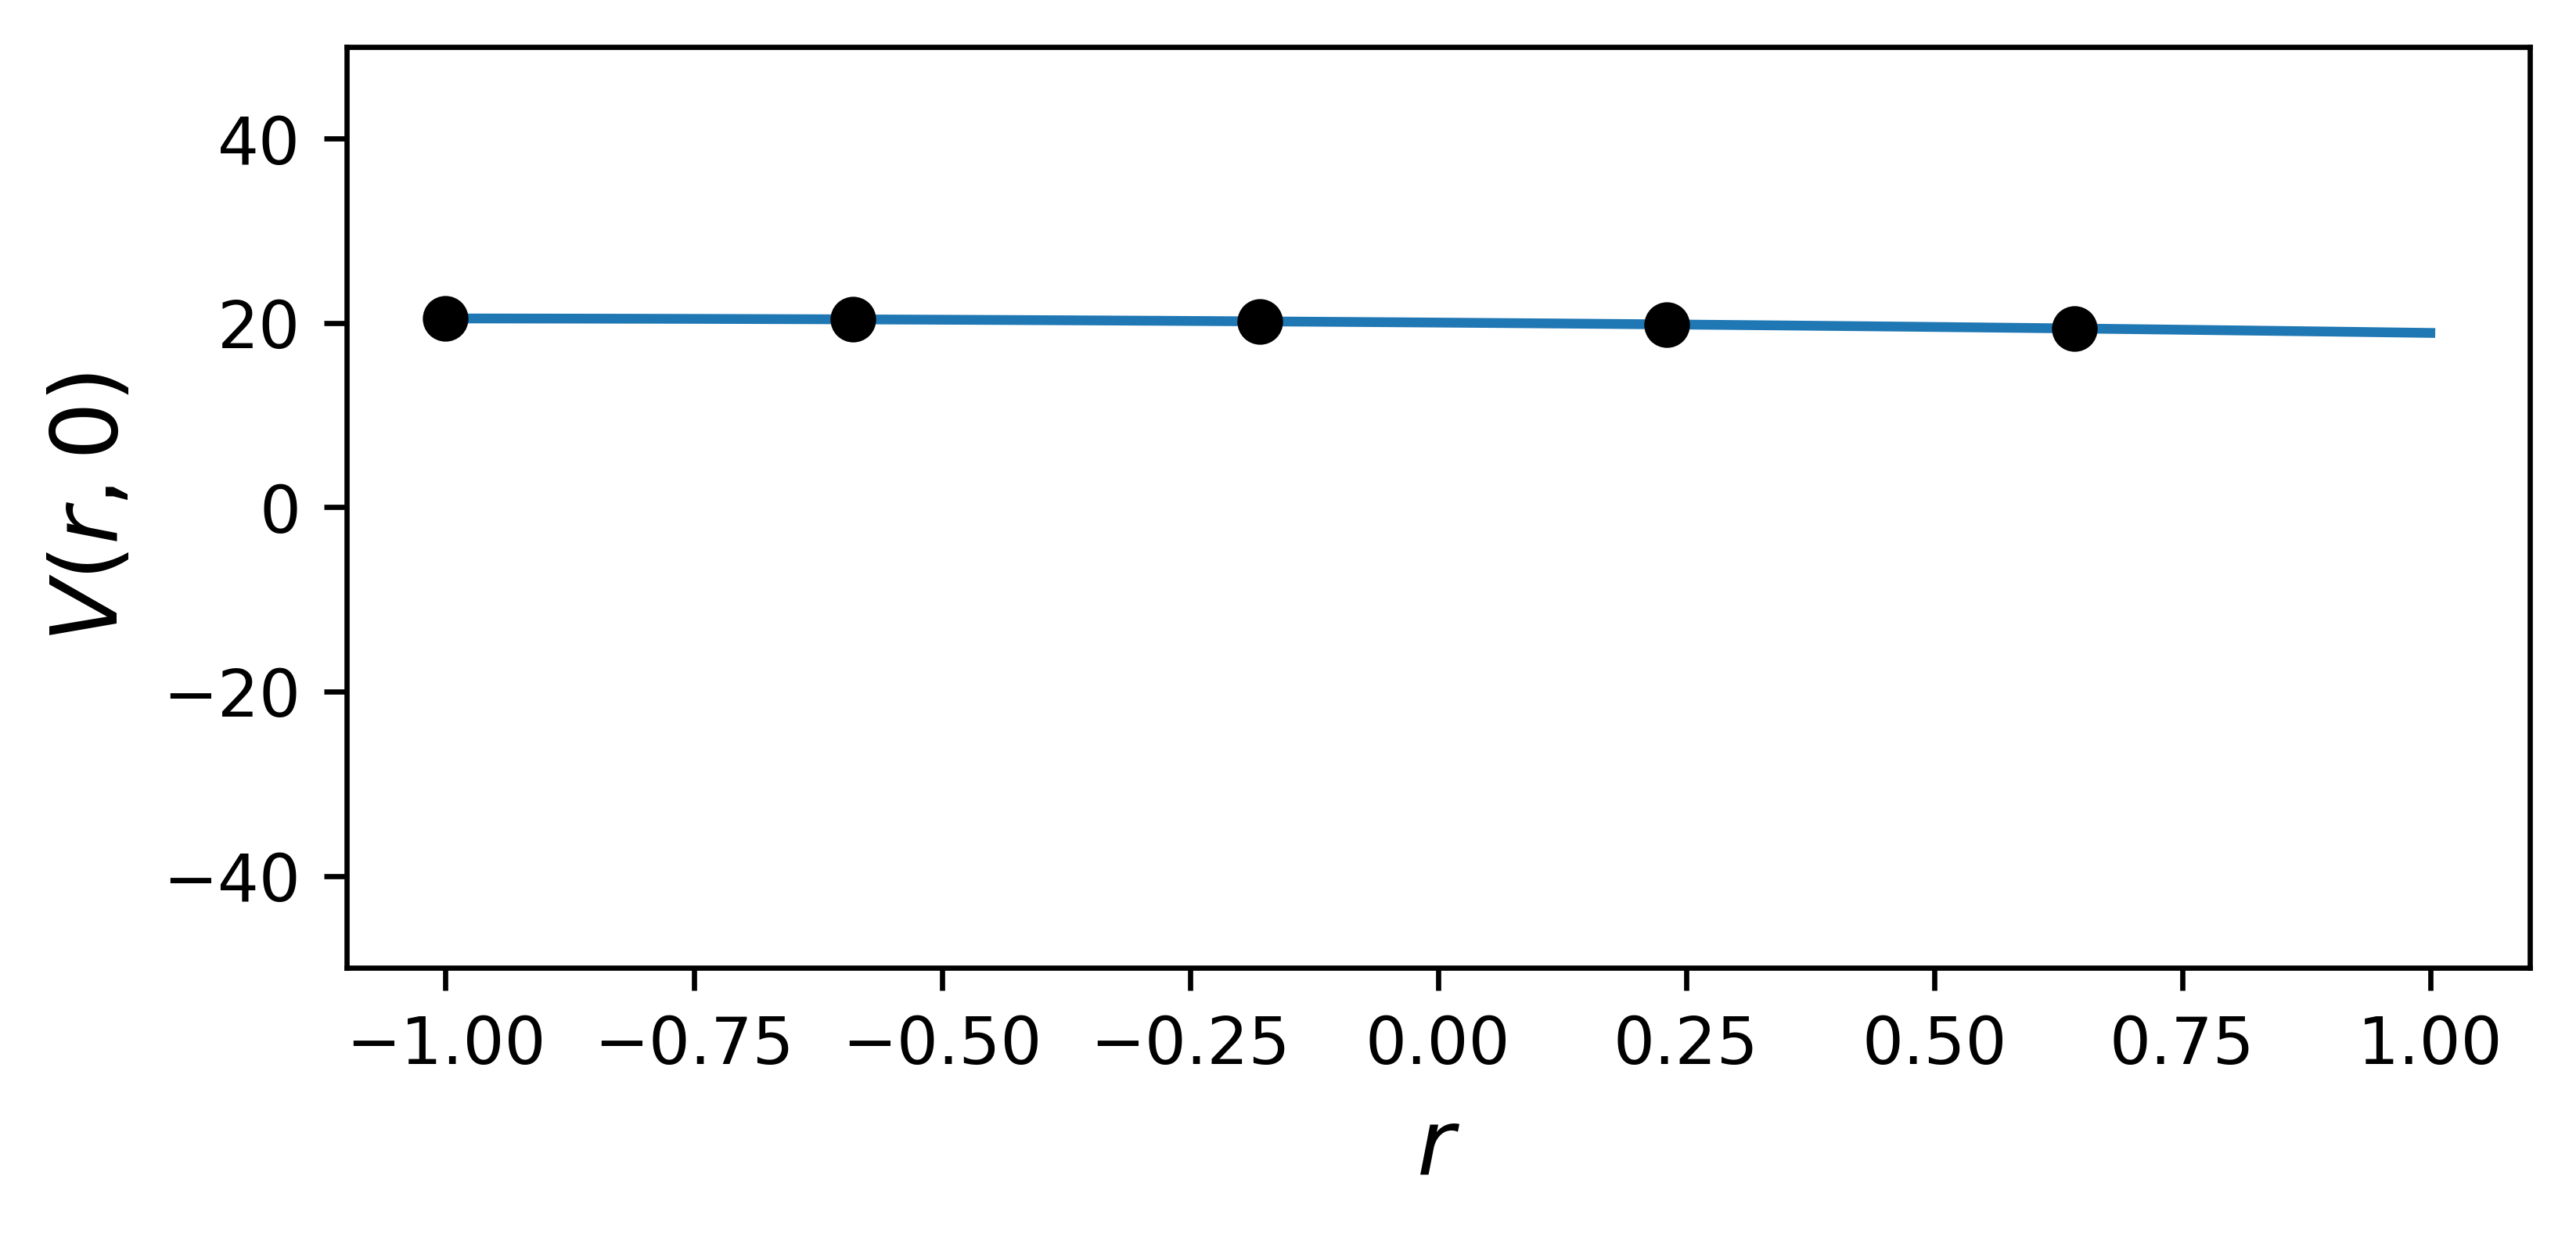

In [15]:
V_q = model.ode.V_net(r_cos_phi_sin_phi).detach().cpu().numpy()
markers_on = [0, 8, 16, 24, 32]
fig = plt.figure(figsize=[6, 2.6], dpi=DPI)
plt.plot(r, V_q, marker = 'o', markevery=markers_on, markerfacecolor=(0,0,0,1), markeredgecolor=(0,0,0,1))
plt.xlabel(r"$r$", fontsize=14)
plt.ylabel(r"$V(r, 0)$", fontsize=14)
plt.ylim([-50, 50])

### plot 5 reconstruction images corresponding to the 5 black dots

In [16]:
ones = torch.ones_like(r_cos_phi_sin_phi[:, 0:1])
cart = model.obs_net_1(ones)
pole = model.obs_net_2(ones)

theta1 = model.get_theta_inv(1, 0, r_cos_phi_sin_phi[:, 0], 0, bs=40)
theta2 = model.get_theta_inv(r_cos_phi_sin_phi[:, 1], r_cos_phi_sin_phi[:, 2], r_cos_phi_sin_phi[:, 0], 0, bs=40)

grid1 = F.affine_grid(theta1, torch.Size((40, 1, 64, 64)))
grid2 = F.affine_grid(theta2, torch.Size((40, 1, 64, 64)))

transf_cart = F.grid_sample(cart.view(40, 1, 64, 64), grid1)
transf_pole = F.grid_sample(pole.view(40, 1, 64, 64), grid2)
Xrec = torch.cat([transf_cart, transf_pole, torch.zeros_like(transf_cart)], dim=1)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


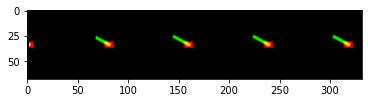

In [17]:
# for i in [0, 8, 16, 24, 32]:
#     fig = plt.figure()
#     plt.imshow(Xrec[i].permute(1,2,0).detach().cpu().numpy())
#     plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'cart_recon_r_{i}.png'), bbox_inches='tight')
grid = utils.make_grid(Xrec[0:40:8])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

# Control

In [18]:
import gym, myenv
import numpy as np
from gym import wrappers
env = gym.make('My_FA_CartPole-v0')

# prepare model instance
model.hparams.solver = 'rk4'
model.bs = 1
model.d = 64

# get a goal image
r_star = 0.0 ; phi_star = 0.0
env.reset()
env.state = np.array([r_star, np.cos(phi_star), np.sin(phi_star), 0.0, 0.0], dtype=np.float32)
goal_frame = env.render(mode='rgb_array')
goal_frame = np.moveaxis(goal_frame, -1, -3) / 255.0
goal_frame = torch.tensor(goal_frame, dtype=torch.float32)
env.close()

# given a goal image, design controller
# first encode the goal image to goal coordinates
goal_r, _, _, _, goal_phi_n = model.encode(goal_frame.view(1, 3, 64, 64))

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
r0, phi0 = 0.9, 3.14

env.reset()
env.state = np.array([r0, 0.0, phi0, 0.0], dtype=np.float32)
frame = env.render(mode='rgb_array')
frame = np.moveaxis(frame, -1, -3) / 255.0
frames = [frame]

frame = torch.tensor(frame, dtype=torch.float32)

for i in range(100):
    r_m, r_v, phi, phi_v, phi_m_n = model.encode(frame.view(1, 3, 64, 64))
    
    if i==0:
        prev_phi_m_n, prev_r_m = phi_m_n, r_m
    r_dot = (r_m - prev_r_m) / 0.05
    phi_dot = model.angle_vel_est(prev_phi_m_n, phi_m_n, 0.05)
    q_dot = torch.cat([r_dot, phi_dot], dim=1)

    r_cos_phi_sin_phi = torch.cat([r_m, phi_m_n], dim=1)
    V_q = model.ode.V_net(r_cos_phi_sin_phi)
    dV = torch.autograd.grad(V_q, r_cos_phi_sin_phi)[0]
    dV_dr, dV_dcos_phi, dV_dsin_phi = dV.split([1, 1, 1], dim=1)
    dV_dphi = dV_dcos_phi * (- phi_m_n[:, 1:2]) + dV_dsin_phi * phi_m_n[:, 0:1]
    g_q = model.ode.g_net(r_cos_phi_sin_phi)
    g_q_T = torch.transpose(g_q, 1, 2)
    inv_g_g_T = torch.inverse(torch.matmul(g_q, g_q_T))
    g_T_inv_g_g_T = torch.matmul(g_q_T, inv_g_g_T)

#     energy_shaping = torch.zeros(2, 1, dtype=torch.float32)
#     energy_shaping[0][0] = dV_dr[0][0] - 3* (r_cos_phi_sin_phi[0][0] - 0.0)
#     energy_shaping[1][0] = 2 * dV_dphi[0][0]

    energy_shaping = torch.zeros(2, 1, dtype=torch.float32)
    energy_shaping[0][0] = dV_dr[0][0] - 3* (r_cos_phi_sin_phi[0][0] - goal_r)
    energy_shaping[1][0] = dV_dphi[0][0] - 20 * (phi_m_n[0, 1] * goal_phi_n[0, 0] - phi_m_n[0, 0] * goal_phi_n[0, 1])

    damping_injection = - 3 * q_dot.T

    u = torch.matmul(g_T_inv_g_g_T, energy_shaping + damping_injection)

    u = u.squeeze().detach().cpu().numpy()
    env.step(u)

    frame = env.render(mode='rgb_array')
    frame = np.moveaxis(frame, -1, -3) / 255.0
    frames.append(frame)
    frame = torch.tensor(frame, dtype=torch.float32)

    prev_phi_m_n, prev_r_m = phi_m_n, r_m

env.close()

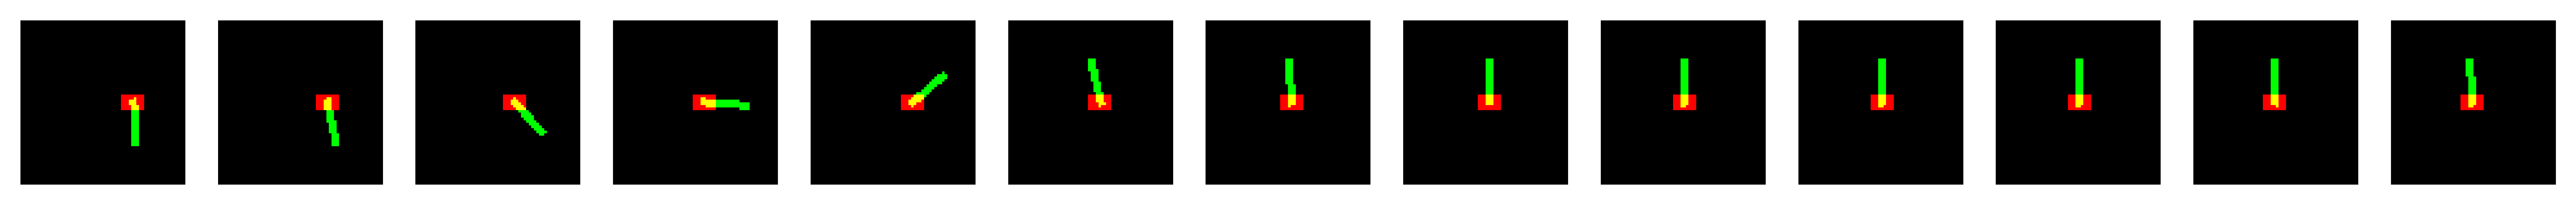

In [20]:
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(np.moveaxis(frames[i*8], -3, -1))
    plt.axis('off')
    
# fig.savefig(os.path.join(PARENT_DIR, 'figures', 'cart-ctrl.png'), bbox_inches='tight')

In [21]:
# new_frames = []
# for frame in frames:
#     new_frames.append(np.moveaxis(frame, -3, -1))

# import imageio
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'cart-ctrl.gif'), new_frames, duration=0.05)

control animation ![control sequence](../figures/cart-ctrl.gif)

In [22]:
model.hparams

"T_pred":                         4
"accumulate_grad_batches":        1
"amp_backend":                    native
"amp_level":                      O2
"auto_lr_find":                   False
"auto_scale_batch_size":          False
"auto_select_gpus":               False
"batch_size":                     1024
"benchmark":                      False
"check_val_every_n_epoch":        1
"checkpoint_callback":            True
"default_root_dir":               None
"deterministic":                  False
"distributed_backend":            None
"early_stop_callback":            False
"fast_dev_run":                   False
"gradient_clip_val":              0
"learning_rate":                  0.001
"limit_test_batches":             1.0
"limit_train_batches":            1.0
"limit_val_batches":              1.0
"log_gpu_memory":                 None
"log_save_interval":              100
"logger":                         True
"max_epochs":                     1000
"max_steps":                     